In [13]:
import numpy as np
from math import log
from scipy import stats
from scipy.stats import multivariate_normal as mvn
from sklearn.cluster import KMeans
import itertools
import matplotlib.pyplot as plt

Each node has a higher number than any of its parents. Start with the low number nodes. Lower number nodes are latent, higher are obs. Graph looks like z -> x

Observations:
changing covariance changes direction of correlation

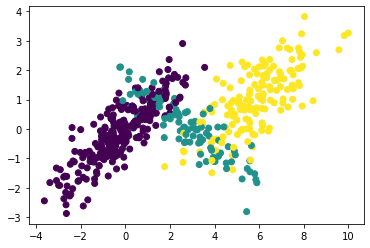

In [10]:
sample_size = 500
real_coef = [0.5,0.2,0.3]

#ancestral sampling
#generate value for z
z=np.random.choice([1,2,3],size=sample_size,p=real_coef)

data = np.empty((sample_size, 2))

real_mu = [[0,0], [3,0], [6,1]]
real_cov = [[[2,1.2],[1.2,1]],
            [[3,-1.5],[-1.5,1]],
            [[2,1],[1,1]]]

for i in range(len(z)):
    if (z[i]==1):
        data[i] = np.random.multivariate_normal(real_mu[0], real_cov[0])
    elif (z[i]==2):
        data[i] = np.random.multivariate_normal(real_mu[1], real_cov[1])
    elif (z[i]==3):
        data[i] = np.random.multivariate_normal(real_mu[2], real_cov[2])

plt.scatter(data[:,0], data[:,1], c=z)

In [18]:
def log_likelihood(resp, mu, cov, coef):
    logl = 0
    for i in range(sample_size):
        logl_i = 0
        for k in range(len(coef)):
            val = coef[k] * mvn(mu[k], cov[k]).pdf(data[i])
            logl_i += val
            resp[i,k] = val
        logl += log(logl_i)
    return logl

def gmm_em_vect(data, kmeans=True):
    #initializations
    if kmeans:
        kmeans = KMeans(3).fit(data)
        mu = kmeans.cluster_centers_
    else:
        mu =  np.random.randn(3,2)
    cov = np.zeros((3,2,2))
    for k in range(len(cov)):
        cov[k] = stats.random_correlation.rvs((1,1))
    coef = np.unique(z, return_counts=True)
    coef = coef[1]/np.sum(coef[1])
    resp = np.zeros((sample_size,3))
    
    logl = log_likelihood(resp, mu, cov, coef)
    
    count = 0
    while True:  
        #E-step
        resp = resp / np.sum(resp, axis=1).reshape(-1,1)

        #M-step
        N_k = np.sum(resp, axis=0).reshape(-1,1)
        mu = resp.T @ data / N_k #want k x dim output, have inputs sample_size x dim and sample_size x k
        #want k x dim x dim output
        cov = np.zeros((3,2,2))
        for k in range(len(coef)):
            y = data - mu[k] # n x dim - 1 x dim -> n x dim
            #stack of n, dxd (dx1 * 1xd) matrices from matmul 2 3d matrices
            cov[k] = 1/N_k[k] * (resp[:,k].reshape(-1,1,1) * y[:,:,None] @ y[:,None,:]).sum(axis=0) # nx1 * nxdxd -> nxdxd
        coef = N_k / np.sum(resp)

        #evaluate log-likelihood
        logl_old = logl
        logl = log_likelihood(resp, mu, cov, coef)
        #also updates resp

        if(abs(logl - logl_old) < .001):
            break;

        print(logl)
        count += 1

    print(count)
    print("Real mu: ")
    print(real_mu)
    print("Estimated mu: ")
    print(mu)

In [19]:
gmm_em_vect(data)

-1784.3702440068396
-1774.8657319476017
-1769.8439397495224
-1765.7285039573032
-1761.6979918628113
-1757.2778071934235
-1752.0220483099993
-1745.9821609034582
-1740.6194915958943
-1737.2801397921323
-1735.653014322734
-1734.9221538962167
-1734.5780999152587
-1734.4017590988467
-1734.3056910628754
-1734.2517304520145
-1734.2210396687774
-1734.203509407297
-1734.1934866508957
-1734.1877573332808
-1734.1844839162452
-1734.1826146124536
-1734.181547587146
23
Real mu: 
[[0, 0], [3, 0], [6, 1]]
Estimated mu: 
[[ 2.904e+00  4.917e-03]
 [ 5.845e+00  1.039e+00]
 [-2.476e-01 -1.273e-01]]
